In [1]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates
from datetime import datetime

In [10]:
df=pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [11]:
#Convert Month object into datetime
df['Month'] = pd.to_datetime(df.Month)
df = df.set_index(df.Month)
df.drop('Month', axis = 1, inplace = True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [12]:
ts = df['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

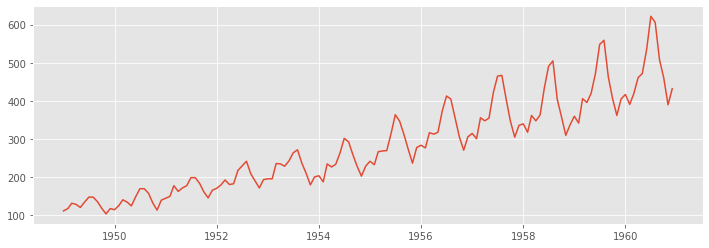

In [13]:
#fluctuation of customer traffic within october
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,4)
plt.plot(ts)
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary
# A function defined for Dickey Fuller Test
def adfuller_test(births):
    result=adfuller(births)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.1:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [48]:
#dickey fuller test for ts
adfuller_test(ts)

ADF Test Statistic : 0.8153688792060418
p-value : 0.9918802434376409
#Lags Used : 13
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


***Since there is a significant positive trend,we can apply log transformation to penalize higher values more than smaller values.***

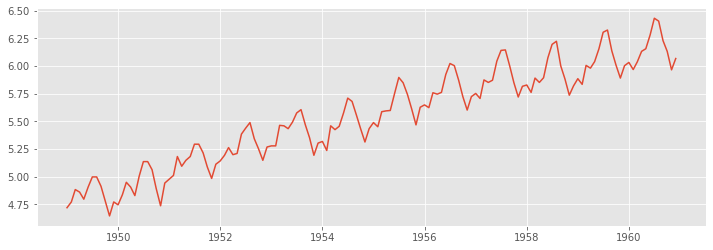

In [49]:
#Taking a log transform
ts_log = np.log(ts)
plt.plot(ts_log)

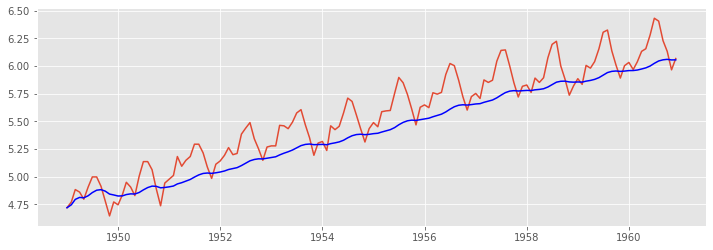

In [50]:
#Exponentially weighted average to smoothen out the curve
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'blue')

In [51]:
#Getting the residual so as to understand whether exponentially weighted average could understand the trend or not
#by performing dickey fuller test
ts_log_ewm_diff = ts_log - exp_weighted_avg
adfuller_test(ts_log_ewm_diff)

ADF Test Statistic : -3.601262420161687
p-value : 0.005736938801511691
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


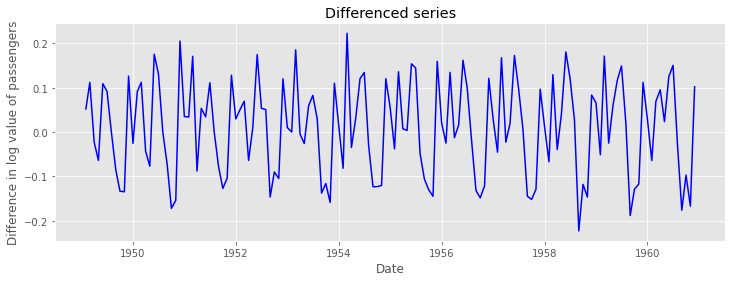

In [52]:
#a one shift difference for ts_log just as an attempt to check another stationarity
from statsmodels.tsa.statespace.tools import diff
fig = plt.figure(figsize=(12,4))
plt.plot(diff(ts_log),color='b');
plt.xlabel('Date')
plt.ylabel('Difference in log value of passengers')
plt.title('Differenced series')
plt.show()

In [53]:
#Dickey Fuller test for one shift
adfuller_test(diff(ts_log))

ADF Test Statistic : -2.7171305983881044
p-value : 0.07112054815086355
#Lags Used : 14
Number of Observations Used : 128
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


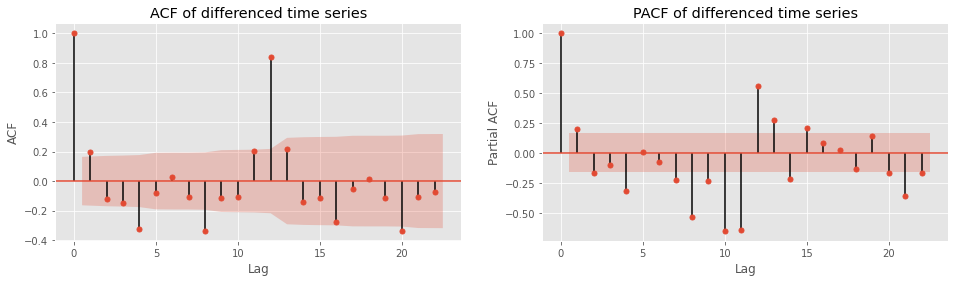

In [59]:
#plot PACF and ACF to obtain orders of AR and MA values.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,2,1)
plot_acf(diff(ts_log), title='ACF of differenced time series',ax=ax1 )
plt.xlabel('Lag')
plt.ylabel('ACF')
ax2 = plt.subplot(1,2,2)
plot_pacf(diff(ts_log), title='PACF of differenced time series',ax=ax2)
plt.xlabel('Lag')
plt.ylabel('Partial ACF')
plt.show()

### Using widely used difference operation and hence We can think of three cases taking AR(1) or MA(1) or ARIMA(1,1,1)

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 121.754
Method:                       css-mle   S.D. of innovations              0.103
Date:                Mon, 08 Feb 2021   AIC                           -237.507
Time:                        13:59:50   BIC                           -228.619
Sample:                    02-01-1949   HQIC                          -233.895
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0097      0.011      0.887      0.377      -0.012       0.031
ma.L1.D.#Passengers     0.2722      0.095      2.873      0.005       0.086       0.458
                

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5245')

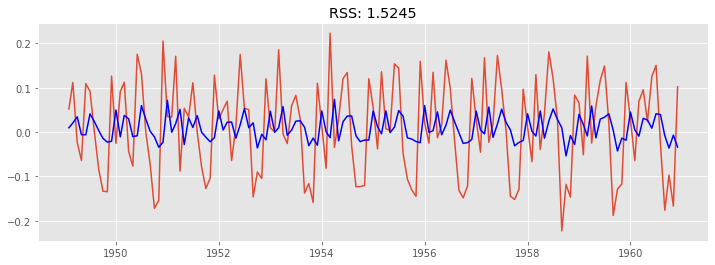

In [22]:
#Analysing MA(1) Model and plotting its graph 
from statsmodels.tsa.arima_model import ARIMA
model1 = ARIMA(ts_log, order=(0,1,1))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())
residuals = pd.DataFrame(model1_fit.resid)
model1_sse = sum((residuals**2).values)
model1_aic = model1_fit.aic
plt.plot(diff(ts_log))
plt.plot(model1_fit.fittedvalues, color = 'blue')
plt.title('RSS: %.4f'% model1_sse )

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 120.693
Method:                       css-mle   S.D. of innovations              0.104
Date:                Mon, 08 Feb 2021   AIC                           -235.386
Time:                        14:00:05   BIC                           -226.497
Sample:                    02-01-1949   HQIC                          -231.774
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0097      0.011      0.892      0.374      -0.012       0.031
ar.L1.D.#Passengers     0.1997      0.082      2.438      0.016       0.039       0.360
                

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5476')

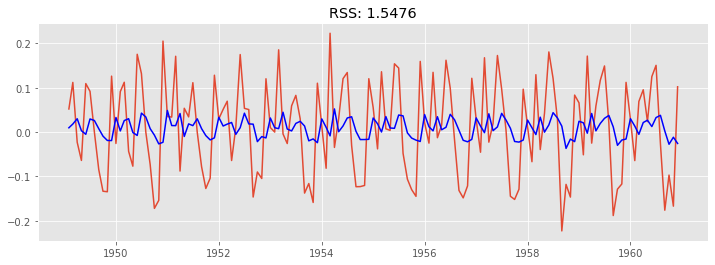

In [23]:
#Analysing AR(1) Model and plotting its graph 
model2 = ARIMA(ts_log, order=(1,1,0))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())
residuals = pd.DataFrame(model2_fit.resid)
model2_sse = sum((residuals**2).values)
model2_aic = model2_fit.aic
plt.plot(diff(ts_log))
plt.plot(model2_fit.fittedvalues, color = 'blue')
plt.title('RSS: %.4f'% model2_sse )

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 124.804
Method:                       css-mle   S.D. of innovations              0.101
Date:                Mon, 08 Feb 2021   AIC                           -241.608
Time:                        14:00:31   BIC                           -229.756
Sample:                    02-01-1949   HQIC                          -236.792
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0098      0.010      0.993      0.322      -0.010       0.029
ar.L1.D.#Passengers    -0.5826      0.128     -4.536      0.000      -0.834      -0.331
ma.L1.D.#Passeng

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4597')

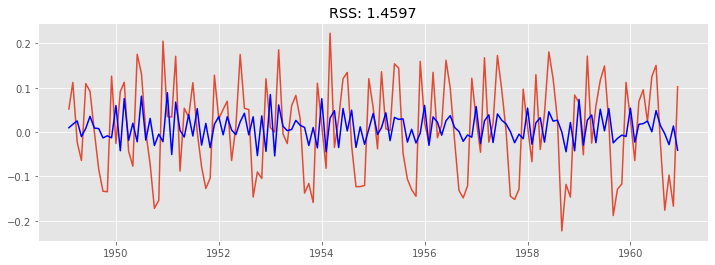

In [24]:
#Analysing ARIMA(1,1,1) Model and plotting its graph 
model3 = ARIMA(ts_log, order=(1,1,1))
model3_fit = model3.fit(disp=0)
print(model3_fit.summary())
residuals = pd.DataFrame(model3_fit.resid)
model3_sse = sum((residuals**2).values)
model3_aic = model3_fit.aic
plt.plot(diff(ts_log))
plt.plot(model3_fit.fittedvalues, color = 'blue')
plt.title('RSS: %.4f'% model3_sse )

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Mon, 08 Feb 2021   AIC                           -287.281
Time:                        14:00:46   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.#Passeng

Text(0.5, 1.0, 'RSS: 1.0292')

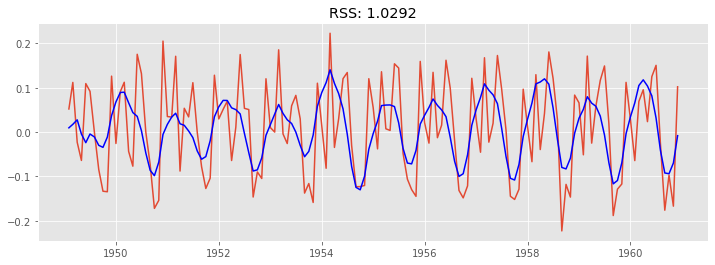

In [25]:
#Analysing ARIMA(2,1,2) Model and plotting its graph 
model4 = ARIMA(ts_log, order=(2,1,2))
model4_fit = model4.fit(disp=0)
print(model4_fit.summary())
residuals = pd.DataFrame(model4_fit.resid)
model4_sse = sum((residuals**2).values)
model4_aic = model4_fit.aic
plt.plot(diff(ts_log))
plt.plot(model4_fit.fittedvalues, color = 'blue')
plt.title('RSS: %.4f'% model4_sse )

In [26]:
#Analysing AIC and SSE of all 4 models
results_df = pd.DataFrame({
    'Arima(0,1,1)': [model1_aic, "{:.3f}".format(model1_sse[0])], 
    'Arima(1,1,0)': [model2_aic, "{:.3f}".format(model2_sse[0])],
    'Arima(1,1,1)': [model3_aic, "{:.3f}".format(model3_sse[0])],
    'Arima(2,1,2)': [model4_aic, "{:.3f}".format(model4_sse[0])]
}, index=['AIC', 'SSE'])

results_df.head()

,"Arima(0,1,1)","Arima(1,1,0)","Arima(1,1,1)","Arima(2,1,2)"
AIC,-237.507,-235.386,-241.608,-287.281
SSE,1.525,1.548,1.460,1.029


### Predictions by my best model which is ARIMA(2,1,2)

In [27]:
predictions_diff_log = pd.Series(model4_fit.fittedvalues, copy=True)
print("The predicted log residuals are like this")
print(predictions_diff_log.head())
print("Predictions similar to what we had before taking residuals of log")
predictions_diff_log_cumsum = predictions_diff_log.cumsum()
predictions_diff_log_cumsum.head()

The predicted log residuals are like this
Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64
Predictions similar to what we had before taking residuals of log


Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [28]:
#The first value which was subtracted in log operation
pd.Series(ts_log.iloc[0], index=ts_log.index).head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

In [29]:
#The predictions just after the log operation took place resemble values like these
predictions_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_log = predictions_log.add(predictions_diff_log_cumsum,fill_value=0)
print('The predictions just after the log operation took place resemble values like these')
predictions_log.head()

The predictions just after the log operation took place resemble values like these


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1046')

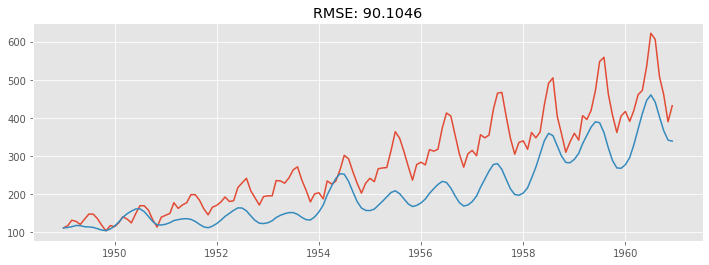

In [30]:
#Since I applied log operation before differencing, its effect had to be restored so exponents had to be taken
predictions_ARIMA = np.exp(predictions_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

### Now Prediction isn't nice, something seems to be missing and we can easily see a seasonal characteristic which we didn't encounter earlier.

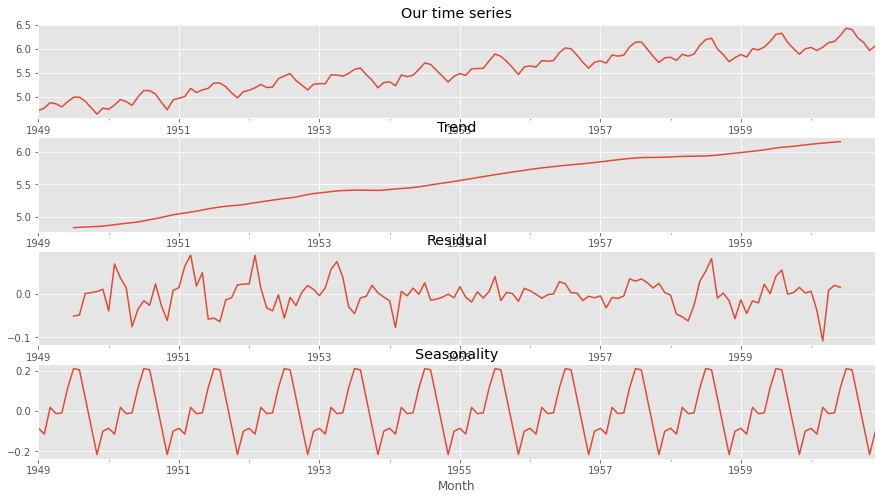

In [31]:
# Additive Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose# Decompose time series into daily trend, seasonal, and residual components.
decomp = seasonal_decompose(ts_log, model = 'additive')# Plot the decomposed time series to interpret.
fig, (ax0, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8));
decomp.observed.plot(ax=ax0, title='Our time series');
decomp.trend.plot(ax=ax1, title='Trend');
decomp.resid.plot(ax=ax2, title='Residual');
decomp.seasonal.plot(ax=ax3, title='Seasonality');

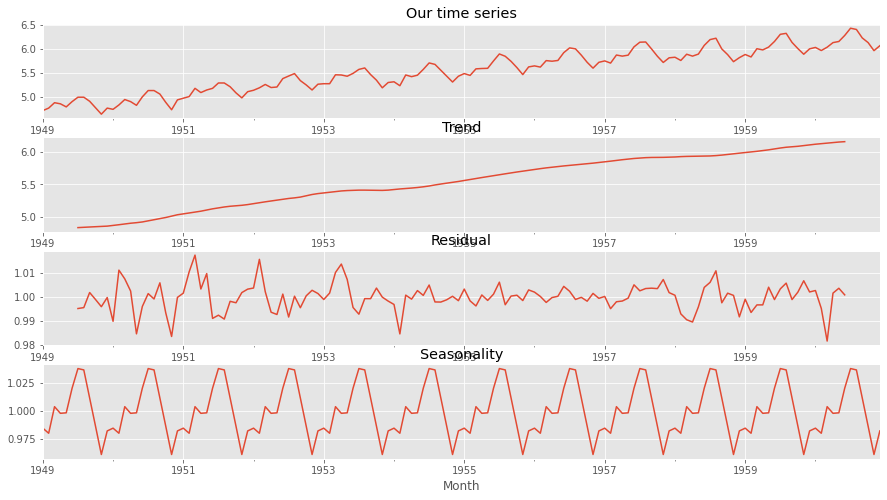

In [32]:
# Multiplicative Decomposition
decomp = seasonal_decompose(ts_log, model = 'multiplicative')# Plot the decomposed time series to interpret.
fig, (ax0, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8));
decomp.observed.plot(ax=ax0, title='Our time series');
decomp.trend.plot(ax=ax1, title='Trend');
decomp.resid.plot(ax=ax2, title='Residual');
decomp.seasonal.plot(ax=ax3, title='Seasonality');

## SARIMA

In [33]:
import itertools
q = [1,2]
p = [1,2]
d = [0,1]
pdq = list(itertools.product(p, d, q))
print(pdq)
#Generate all different combinations of seasonal p, q and q triplet
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(seasonal_pdq)

[(1, 0, 1), (1, 0, 2), (1, 1, 1), (1, 1, 2), (2, 0, 1), (2, 0, 2), (2, 1, 1), (2, 1, 2)]
[(1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 1, 12), (1, 1, 2, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 1, 12), (2, 1, 2, 12)]


In [34]:
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (1, 0, 2) x (1, 0, 2, 12)
SARIMAX: (1, 0, 2) x (1, 1, 1, 12)
SARIMAX: (1, 1, 1) x (1, 1, 2, 12)
SARIMAX: (1, 1, 1) x (2, 0, 1, 12)


In [35]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")           #Specify to ignore warning messages
AIC_df = pd.DataFrame({}, columns = ['param', 'param_seasonal', 'AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log, order = param, seasonal_order = param_seasonal, 
            enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit()
            temp = pd.DataFrame([[param, param_seasonal, results.aic]], columns = ['param', 'param_seasonal', 'AIC'])
            AIC_df = AIC_df.append(temp, ignore_index = True)
            del temp
        except:
            continue

In [37]:
AIC_df.head()

,param,param_seasonal,AIC
0,"(1, 0, 1)","(1, 0, 1, 12)",-477.619383
1,"(1, 0, 1)","(1, 0, 2, 12)",-428.989465
2,"(1, 0, 1)","(1, 1, 1, 12)",-431.572183
3,"(1, 0, 1)","(1, 1, 2, 12)",-398.431031
4,"(1, 0, 1)","(2, 0, 1, 12)",-434.693439


In [38]:
#To get the best results based on the lowest AIC score
min_aic = AIC_df.sort_values(by = 'AIC').iloc[0]    #Row with minimum AIC value
model = sm.tsa.statespace.SARIMAX(ts_log, order = min_aic.param,seasonal_order = min_aic.param_seasonal, 
enforce_stationarity = False, enforce_invertibility = False)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 243.810
Date:                            Mon, 08 Feb 2021   AIC                           -477.619
Time:                                    14:08:57   BIC                           -463.282
Sample:                                01-01-1949   HQIC                          -471.794
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.039     24.099      0.000       0.865       1.019
ma.L1         -0.3803      0.093   

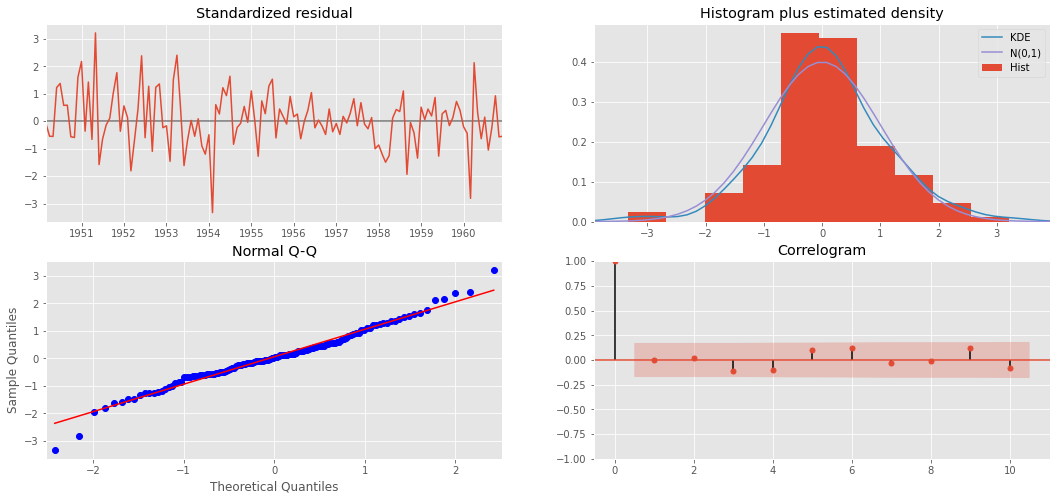

In [39]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()


*Model diagnostics suggests that the residuals of our model aren't correlated and are normally distributed with 0 mean. The qq-plot shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1) and the correlogram depicts that the time series residuals have low correlation with lagged versions of itself.*

# Steps for ARIMA implementation
**The general steps to implement an ARIMA model are –**

1) **Load the data**: *The first step for model building is of course to load the dataset.*
<br>
2) **Preprocessing**: *Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.* 
<br>
3) **Make series stationary**: *In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations*
<br>
4) **Determine d value**: *For making the series stationary, the number of times the difference operation was performed will be taken as the d value*
<br>
5) **Create ACF and PACF plots**: *This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model*
<br>
6)**Determine the p and q values**: *Read the values of p and q from the plots in the previous step.*
<br>
7) **Fit ARIMA model**: *Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model*
<br>
8) **Predict values on validation set**: *Predict the future values*
<br>
9) **Calculate RMSE**: *To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set. *

In [40]:
df=pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## What Auto ARIMA does?
*Before implementing ARIMA, the series has to be made stationary,and determine the values of p and q using the plots we discussed above. Auto ARIMA makes this task really simple for us as it eliminates steps 3 to 6 displayed in the ARIMA section.* 

# Steps for Auto-ARIMA implementation
**The general steps to implement an Auto-ARIMA model are –**

1) **Load the data**: *The first step for model building is of course to load the dataset.*
<br>
2) **Preprocessing**: *Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.* 
<br>
3) **Fit Auto ARIMA**: *Using the processed data and parameter values we calculated from the previous steps, fit the Auto-ARIMA model*
<br>
4) **Predict values on validation set**: *Predict the future values*
<br>
5) **Calculate RMSE**: *To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set.* 

In [45]:

  
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(ts, start_p = 0, start_q = 0, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1030.752, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.43 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.34 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.59 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.30 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.65 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.86 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.51 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=3.50 sec
 ARIMA(0,1,1)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -505.589
Date:                            Mon, 08 Feb 2021   AIC                           1019.178
Time:                                    14:26:55   BIC                           1030.679
Sample:                                         0   HQIC                          1023.851
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (Q):                       53.71   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.07   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# Split data into train / test sets 
train = df.iloc[:len(df)-12] 
test = df.iloc[len(df)-12:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 0, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['#Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -446.830
Date:                            Mon, 08 Feb 2021   AIC                            901.659
Time:                                    14:27:08   BIC                            912.776
Sample:                                         0   HQIC                           906.173
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2556      0.080     -3.190      0.001      -0.413      -0.099
ar.S.L12      -0.0962      0.090     -1.073      0.283      -0.272       0.080
ar.S.L24       0.1454      0.101      1.445      0.149      -0.052       0.343
sigma2       106.2408     15.243      6.970      0.000      76.364     136.117
===================================================================================
Ljung-Box (Q):                       42.14   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.38   Prob(JB):                         0.99
Heteroskedasticity (H):               1.63   Skew:                             0.01
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

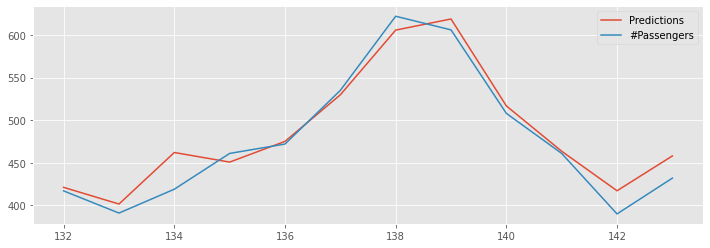

In [47]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['#Passengers'].plot(legend = True) 